In [1]:
import numpy as np
import scipy as sp
from scipy import interpolate

from astropy.table import Table
#import picca.wedgize
import fitsio as fitsio

import matplotlib.pyplot as plt
from desispec.interpolation import resample_flux
import timeit

import h5py  #fit data

%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 9) # (w, h)
plt.rcParams.update({'font.size': 18})

In [2]:

class wedge:
    def __init__(self,rpmin=0.,rpmax=200.,nrp=50,rtmin=0.,rtmax=200.,nrt=50,\
            rmin=0.,rmax=200.,nr=50,mumin=0.8,mumax=0.95,ss=10,absoluteMu=False):
        nrtmc = ss*nrt
        nrpmc = ss*nrp
        nss=nrtmc*nrpmc
        index=np.arange(nss)
        irtmc=index%nrtmc
        irpmc=(index-irtmc)//nrtmc
        rtmc = rtmin+(irtmc+0.5)*(rtmax-rtmin)/nrtmc
        rpmc = rpmin+(irpmc+0.5)*(rpmax-rpmin)/nrpmc
        rmc = np.sqrt(rtmc**2+rpmc**2)
        mumc = rpmc/rmc
        if absoluteMu:
            mumc = np.absolute(mumc)

        br = (rmc-rmin)/(rmax-rmin)*nr
        br = br.astype(int)

        bt = (rtmc-rtmin)/(rtmax-rtmin)*nrt
        bt = bt.astype(int)

        bp = (rpmc-rpmin)/(rpmax-rpmin)*nrp
        bp = bp.astype(int)

        r_par = rpmin + (bp+0.5)*(rpmax-rpmin)/nrp
        r_trans = rtmin + (bt+0.5)*(rtmax-rtmin)/nrt
        r=np.sqrt(r_par**2+r_trans**2)

        bins = bt+nrt*bp + nrp*nrt*br

        w = (mumc>=mumin) & (mumc<=mumax) & (r<rmax) & (r>rmin) & (br<nr)
        bins = bins[w]

        W = np.zeros(nrp*nrt*nr)
        c=np.bincount(bins.flatten())
        W[:len(c)]+=c

        self.W = W.reshape(nr,nrt*nrp)
        self.r = rmin + (np.arange(nr)+0.5)*(rmax-rmin)/nr

    def wedge(self,da,co):
        we = 1/np.diagonal(co)
        w = self.W.dot(we)
        Wwe = self.W*we
        mask = w>0
        Wwe[mask,:]/=w[mask,None]
        d = Wwe.dot(da)
        return self.r,d,Wwe.dot(co).dot(Wwe.T)

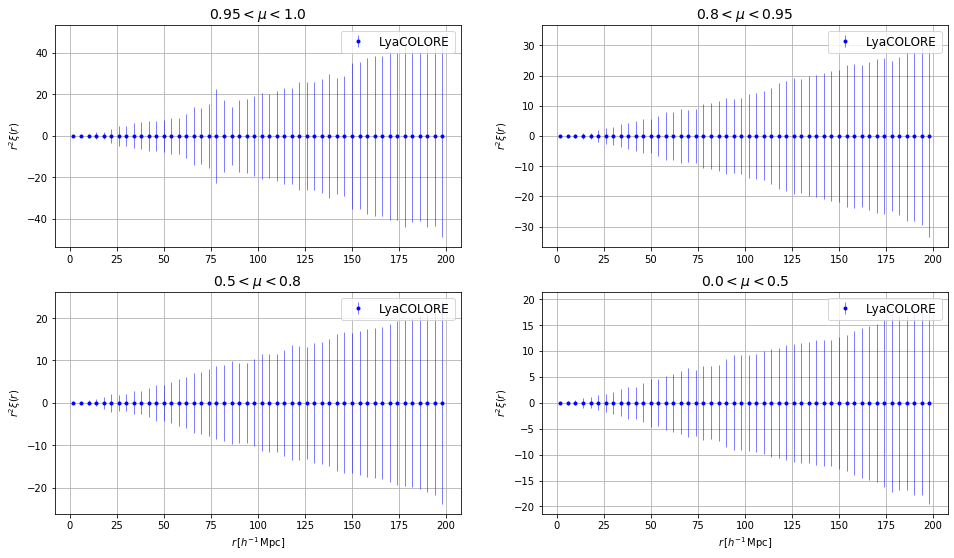

In [7]:
mus = [1., 0.95, 0.8, 0.5, 0.]
power = 2
f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(16,9))

corr1 = '/work/sfbeltranv/output_deltas/out/e_cf.fits.gz'
corr2 = '/work/sfbeltranv/output_deltas_lya/out/e_cf.fits.gz'
fit1 = '/work/sfbeltranv/output_deltas/fit/out/result.h5'
fit2 = '/work/sfbeltranv/output_deltas_lya/fit/out/result.h5'



h1 = fitsio.FITS(corr1)
h2 = fitsio.FITS(corr2)

da1 = h1[1]['DA'][:]
co1 = h1[1]['CO'][:]
da2 = h2[1]['DA'][:]
co2 = h2[1]['CO'][:]


rpmin = h1[1].read_header()['RPMIN']
npp = h1[1].read_header()['NP']

h1.close()
h2.close()

points = 50

rtmin = 0 
rtmax = 200
nrt = points
rpmin = 0 
rpmax = 200
nrp = points

r_pow = 2

mumin = -1.
mumax = 1.

mu0, mu1, mu2, mu3, mu4 = 0, 0.5, 0.8, 0.95, 1
mumin = mu0
mumax = mu1


mus = [1., 0.95, 0.8, 0.5, 0.]


for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
   b = wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=npp,absoluteMu=True)
   r1,d1,c1 = b.wedge(da1,co1)
   r2,d2,c2 = b.wedge(da2,co2)
   
   
   f1 = h5py.File('/work/sfbeltranv/output_deltas/fit/out/result.h5', 'r')
   f2 = h5py.File('/work/sfbeltranv/output_deltas_lya/fit/out/result.h5', 'r')
   
   dset1 = f1['e_cf']
   broad1 = dset1['/e_cf']['broadband']
   fit1 = dset1['/e_cf']['fit']
   
   dset2 = f2['e_cf']
   broad2 = dset2['/e_cf']['broadband']
   fit2 = dset2['/e_cf']['fit']
   
   fitreg1 = b.wedge(fit1,co1)
   fitreg2 = b.wedge(fit2,co2)

   if 1:      
      #CF
      axs[i//2][i%2].errorbar(r1,d1*r1**power-d2*r2**power,yerr=np.sqrt(c1.diagonal())*r1**power,fmt="bo",label=r'LyaCOLORE', ms=3, lw=.5)
      #axs[i//2][i%2].errorbar(r2,d2*r2**power,yerr=np.sqrt(c2.diagonal())*r1**power,fmt="ro",label=r'Bld LyaCOLORE ($0.95\Omega_m$)', ms=3, lw=.5)
      #axs[i//2][i%2].plot(r1,d1*r1**power,'b',lw=.5)
      #axs[i//2][i%2].plot(r2,d2*r2**power,'r',lw=.5)
   if 0:
      #fits
      axs[i//2][i%2].plot(fitreg1[0],fitreg1[0]**2 *fitreg1[1],'b')#,label='LyaCOLORE')
      axs[i//2][i%2].plot(fitreg2[0],fitreg2[0]**2 *fitreg2[1],'r')#,label=r'Bld LyaCOLORE ($0.9\Omega_m$)')
   
   
   axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
   if i//2==1:
     axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
   axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=14)
   axs[i//2][i%2].legend(fontsize=12)
   axs[i//2][i%2].grid()


plt.show()


